In [247]:
from math import tan, pi, cos, sin
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import torch
import os
import itertools


In [741]:
class LabelDataset(tfds.core.GeneratorBasedBuilder):
    VERSION = tfds.core.Version("1.0.0")
    RELEASE_NOTES = {"1.0.0" : "Initial release."}
    SUPPORTED_VERSIONS = [tfds.core.Version("1.0.0")]

    def _get_num_samples(self):

        mask_sample_path = os.path.join(self.video_paths[0], 'mask.npy')
        mask_shapes = np.load(mask_sample_path).shape
        self.num_samples = mask_shapes[0] * len(self.video_paths)

    def _init_camera_params(self):
        # Default camera parameters for the CLEVR dataset
        self.default_camera_params = {
            'fov': 49.9,  # Field of view in degrees
            'camera_position': [3, 3, 6],  # Camera position (x, y, z)
            'camera_rotation': [-25, 25, 0],  # Camera rotation in degrees (pitch, roll, yaw)
            'camera_sensor_width': 36,  # Camera sensor width in mm
            'camera_sensor_height': 24,  # Camera sensor height in mm
            'image_resolution': [320, 240]  # Image resolution (width, height)
        }
        
        # Calculate the pixel dimensions
        self.width, self.height = self.default_camera_params['image_resolution']
        self.pixel_width = self.default_camera_params['camera_sensor_width'] / self.width
        self.pixel_height = self.default_camera_params['camera_sensor_height'] / self.height
        
        # Calculate the camera rotation matrix
        pitch = self.default_camera_params['camera_rotation'][0] * pi / 180
        roll = self.default_camera_params['camera_rotation'][1] * pi / 180
        yaw = self.default_camera_params['camera_rotation'][2] * pi / 180
        
        self.rotation_matrix = np.array([
            [cos(yaw) * cos(pitch), cos(yaw) * sin(pitch) * sin(roll) - sin(yaw) * cos(roll), cos(yaw) * sin(pitch) * cos(roll) + sin(yaw) * sin(roll)],
            [sin(yaw) * cos(pitch), sin(yaw) * sin(pitch) * sin(roll) + cos(yaw) * cos(roll), sin(yaw) * sin(pitch) * cos(roll) - cos(yaw) * sin(roll)],
            [-sin(pitch), cos(pitch) * sin(roll), cos(pitch) * cos(roll)]]
        )

    def _init_mappings(self):

        self.code_characteristics = {}
        counter = 1
        shapes = ['cube', 'sphere', 'cylinder']
        materials = ['metal', 'rubber']
        colors = ['gray', 'red', 'blue', 'green', 'brown', 'cyan', 'purple', 'yellow']
        sizes = ['small']
        
        for shape in shapes:
            for material in materials:
                for color in colors:
                    for size in sizes:
                        self.code_characteristics[counter] = {'shape': shape, 'material': material, 'color': color, 'size': size}
                        counter += 1
    
    def maskpixel_to_3D_coordinates(self, x_index, y_index):
        # Convert 2D pixel coordinates to 3D world coordinates
        u = (x_index - self.width / 2) * self.pixel_width
        v = (y_index - self.height / 2) * self.pixel_height
        direction = np.array([u, v, self.default_camera_params['fov'] / 2])
        direction /= np.linalg.norm(direction)
        direction = np.dot(self.rotation_matrix, direction)
        world_coords = self.default_camera_params['camera_position'] + direction

        return world_coords
    
    def _inputs(self):
        return []

    def element_spec(self):
        image_shape = tf.TensorShape([None, None, 3])
        mask_shape = tf.TensorShape([None])
        return (image_shape, mask_shape)

    def _process_image(self, image_data):
        
        image = tf.image.decode_png(image_data, channels=3)
        image = tf.cast(image, tf.float32)
        image = ((image / 255.0) - 0.5) * 2.0  # Rescale to [-1, 1].
        image = tf.image.resize(image, (160,240), method=tf.image.ResizeMethod.BILINEAR)
        image = tf.clip_by_value(image, -1., 1.)
        
        return image

    def _process_mask(self, mask):
        mask = tf.convert_to_tensor(mask)
        unique_mask_codes = np.unique(mask[mask != 0])
        
        mask_shape = []
        mask_material = []
        mask_color = []
        mask_size = []
        mask_3d_coords = []
        mask_mask = []
        mask_code = []
                
        for unique_mask_code in unique_mask_codes:
            unique_mask = mask == unique_mask_code
                    
            true_indices = np.where(unique_mask)
            x_mask, y_mask = (int(np.mean(true_indices[0])), int(np.mean(true_indices[1])))

            mask_object = {}

            mask_shape.append(self.code_characteristics[unique_mask_code]['shape'])
            mask_material.append(self.code_characteristics[unique_mask_code]['material'])
            mask_color.append(self.code_characteristics[unique_mask_code]['color'])
            mask_size.append(self.code_characteristics[unique_mask_code]['size'])
            mask_3d_coords.append(self.maskpixel_to_3D_coordinates(x_mask, y_mask))
            mask_mask.append(unique_mask)
            mask_code.append(unique_mask_code)

        attrs = [
            "color",
            "material",
            "shape",
            "size",
            "3d_coords",
            # "mask",
            # "code",
        ]
        mask_object = {}
        # mask_object['shape'] = tf.stack(mask_shape)
        # mask_object['material'] = tf.stack(mask_material)
        # mask_object['color'] = tf.stack(mask_color)
        # mask_object['size'] = tf.stack(mask_size)
        # mask_object['3d_coords']= tf.stack(mask_3d_coords)
        # mask_object['mask'] = tf.stack(mask_mask)
        # mask_object['code'] = tf.stack(mask_code)
        mask_object['shape'] = mask_shape
        mask_object['material'] = mask_material
        mask_object['color'] = mask_color
        mask_object['size'] = mask_size
        mask_object['3d_coords']= mask_3d_coords
        # mask_object['mask'] = mask_mask
        # mask_object['code'] = mask_code

        mask_object_list = [{attr: mask_object[attr][obj] for attr in attrs} for obj in range(len(mask_material))]

        return mask_object_list

    def _generate_examples(self):
        batch_data = []
        for path in self.video_paths:
            print(path)
            mask_path = os.path.join(path, 'mask.npy')
            masks = np.load(mask_path)

            for i in range(masks.shape[0]): 
                image_path = os.path.join(path, f'image_{i}.png')
                image_data = tf.io.read_file(image_path)
                image = self._process_image(image_data)
                mask_object = self._process_mask(masks[i])
                record = {'image': image_path, 'file_name': f'image_{i}.png','objects': mask_object}
                fname =  image_path
        
                yield fname, record
        #         batch_data.append({'image': tf.stack(image), 'file_name': f'image_{i}.png','objects': mask_object})
        #         if len(batch_data) == self.batch_size:
        #             print(batch_data[0].keys())
        #             print(set(itertools.chain(*batch_data)))
        #             # for key in set(itertools.chain(*batch_data)):  # set merge all keys
        #             #     print(key, tuple(d[key] for d in batch_data))
        #             yield path, batch_data
        #             print('ok')
        #             batch_data = []

        # if len(batch_data) > 0:
        #     print('here')
        #     yield path, batch_data
        

    def _split_generators(self, dl_manager):
        return [
            tfds.core.SplitGenerator(
                name=tfds.Split.TRAIN,
                gen_kwargs={},
            )
        ]

    def _info(self):

        self.video_paths = [os.path.join('/Users/keegankelly/NYU/Classes/Deep_Learning/project/dataset_full/train/', dir_path) for dir_path in os.listdir('/Users/keegankelly/NYU/Classes/Deep_Learning/project/dataset_full/train/') if dir_path.startswith('video')]
        self.batch_size = 2
        self._init_camera_params()
        self._init_mappings()
        self._get_num_samples()

        features = {
            "image": tfds.features.Image(),
            "file_name": tfds.features.Text(),
            "objects": tfds.features.Sequence({
                "shape": tfds.features.ClassLabel(names= ['cube', 'sphere', 'cylinder']),
                "material": tfds.features.ClassLabel(names= ['metal', 'rubber']),
                "color": tfds.features.ClassLabel(names=['gray', 'red', 'blue', 'green', 'brown', 'cyan', 'purple', 'yellow']),
                "size": tfds.features.ClassLabel(names=['small']),
                "3d_coords": tfds.features.Tensor(shape=(3,), dtype=tf.float64),
                # "mask": tfds.features.Tensor(shape=(160, 240), dtype=tf.bool),
                # "code": tfds.features.Tensor(shape=(), dtype=tf.int64),
            }),
        }

        features_dict = tfds.features.FeaturesDict(features)
        dataset_info = tfds.core.DatasetInfo(
            builder=self,
            features=features_dict,
        )
        return dataset_info

In [743]:
custom_dataset_file = LabelDataset()
custom_dataset_file.download_and_prepare()
ds_all_dict = custom_dataset_file.as_dataset()
ds_all_dict

Did not update code below this line:    

In [267]:
unique_values_1 = []
unique_values_2 = []

unique_image_set_1 = []
unique_image_set_2 = []

for img in custom_dataset:
    for data in img:
        for code_indices in range(data['objects']['code'].shape[0]):
            mask_code = data['objects']['code'][code_indices]
            if mask_code not in unique_values_1:
                unique_values_1.append(mask_code)
                unique_values = {}
                
                unique_values['image'] = data['image']
                unique_values['mask'] = data['objects']['mask'][code_indices]
                unique_values['code'] = mask_code
                unique_image_set_1.append(unique_values)
                
            elif mask_code not in unique_values_2:
                unique_values_2.append(mask_code)
                unique_values = {}
                
                unique_values['image'] = data['image']
                unique_values['mask'] = data['objects']['mask'][code_indices]
                unique_values['code'] = mask_code
                unique_image_set_2.append(unique_values)

In [268]:
def visualize_batch_segments(target, image):
    
    np.unique(target[target != 0])
    unique_batches = np.unique(target.numpy())
    num_unique_batches = len(unique_batches)
    
    fig, axes = plt.subplots(1, num_unique_batches, figsize=(5*num_unique_batches, 5))
    axes[0].imshow(tf.cast((image + 1) * (255 / 2), tf.uint8))
    axes[0].set_title(f"Image")
    
    for batch_num in range(1, num_unique_batches):
        # Create a mask for the current batch
        batch_mask = tf.cast(target == unique_batches[batch_num], tf.float32)
        
        # Apply the mask to the image
        masked_image = tf.cast(image, tf.float32) * tf.expand_dims(batch_mask, axis=-1)
        
        # Plot the masked image and the mask itself
        axes[batch_num].imshow(tf.cast((masked_image + 1) * (255 / 2), tf.uint8))
        axes[batch_num].set_title(f"Code {unique_batches[batch_num]} in Image")
        #axes[2].imshow(batch_mask, cmap='gray')
        #axes[2].set_title(f"Segment {batch_num} Mask")
    plt.show()

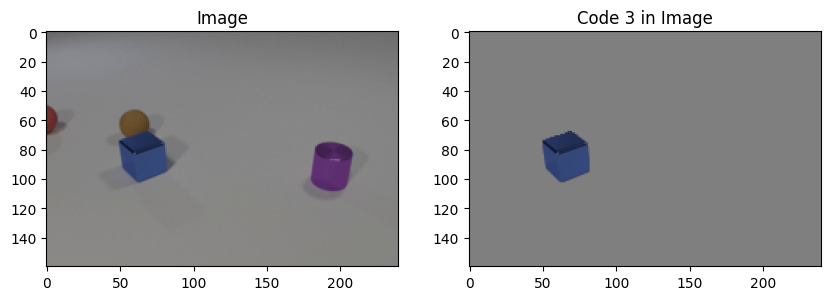

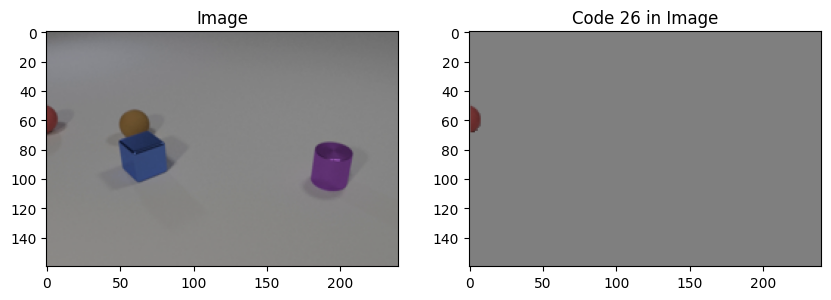

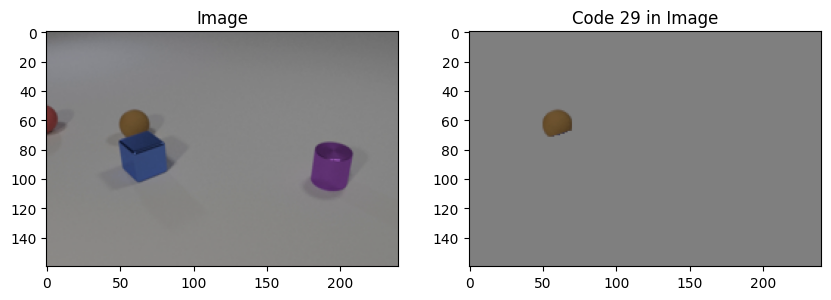

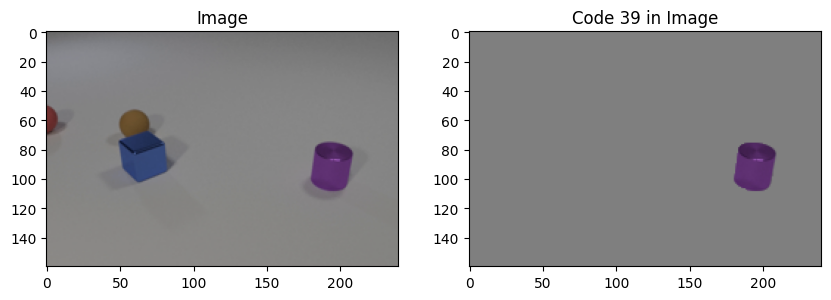

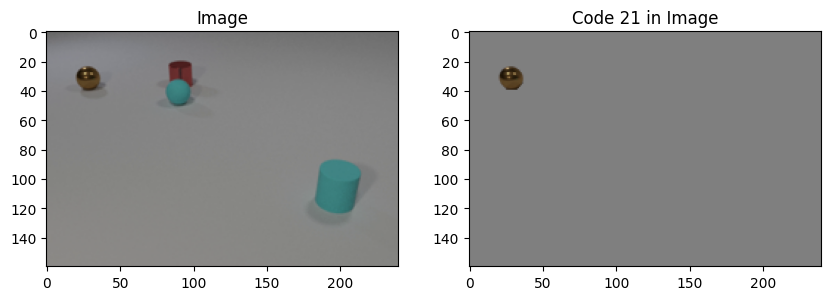

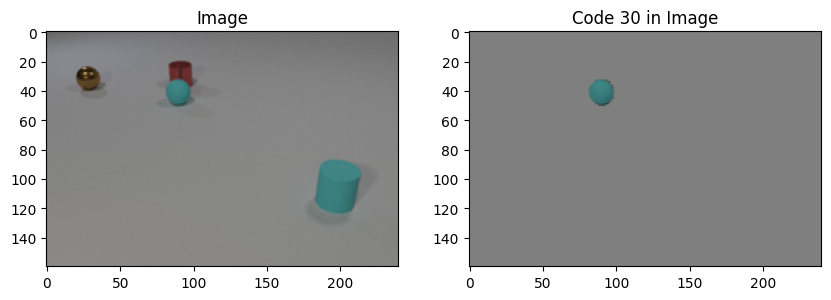

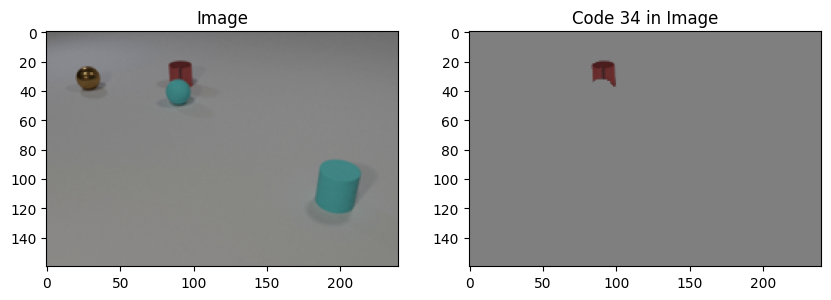

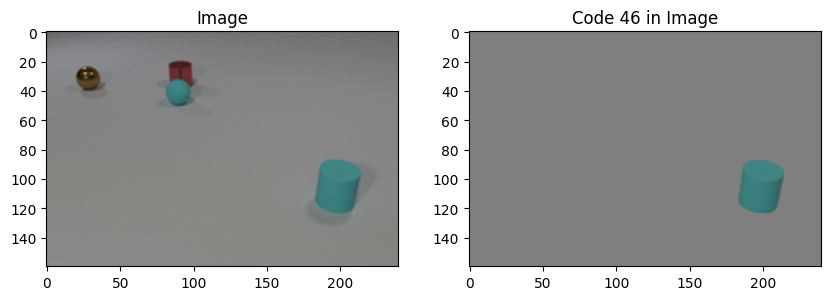

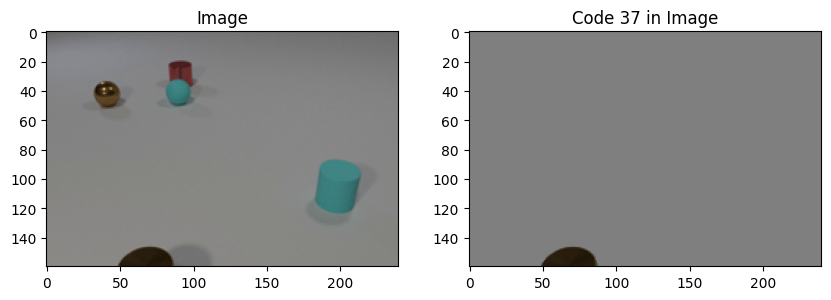

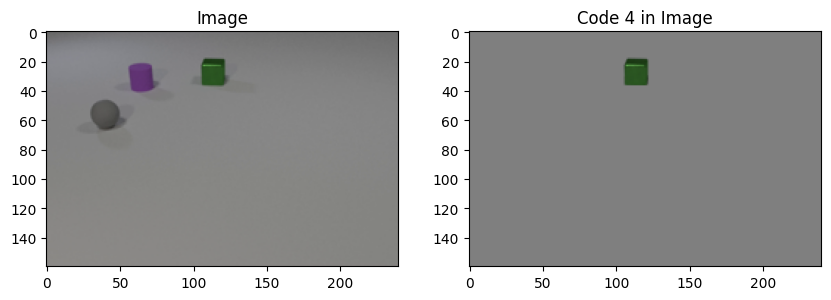

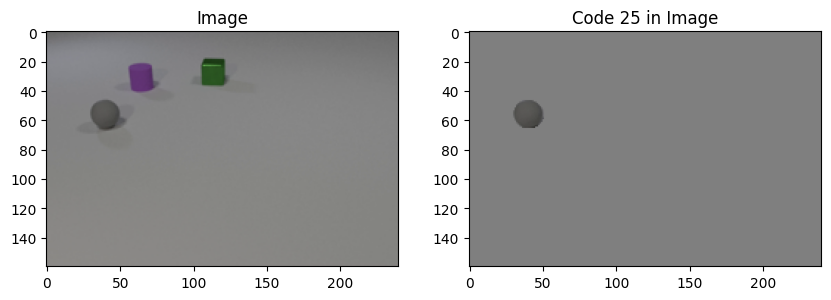

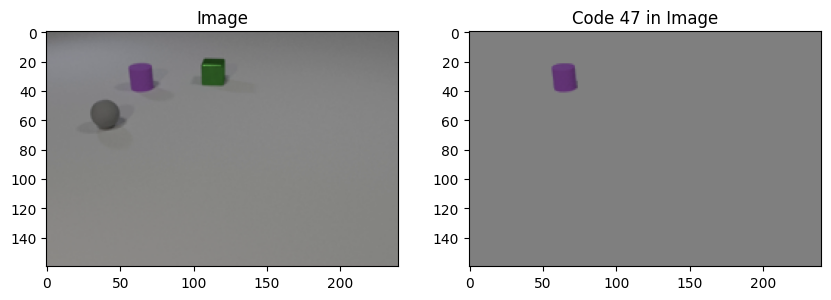

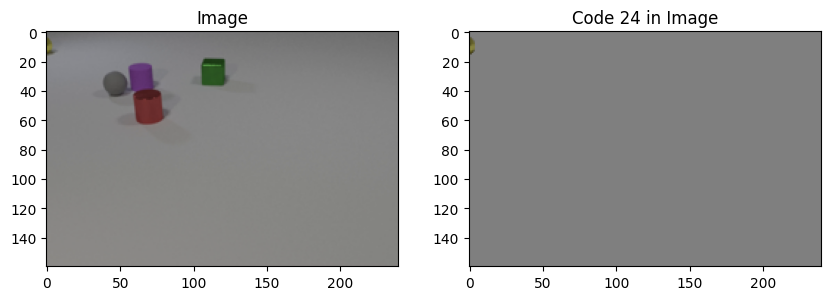

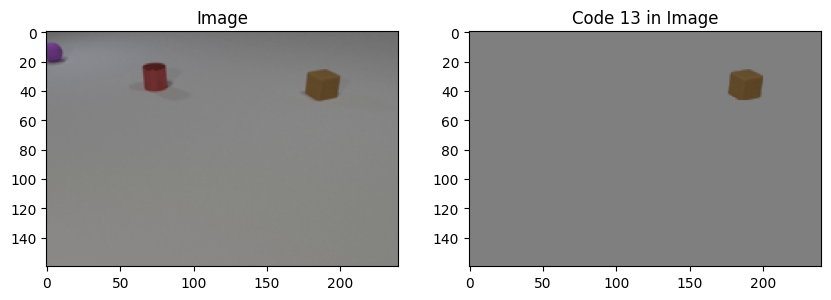

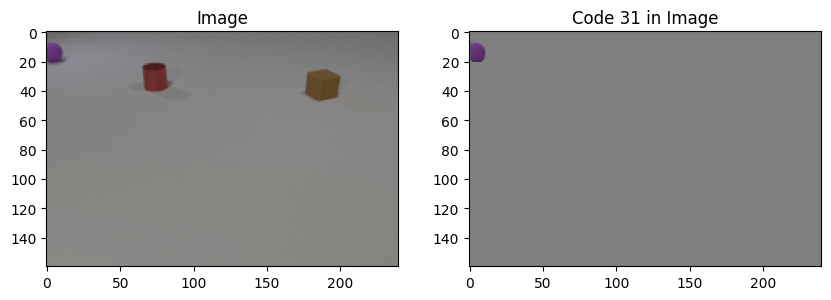

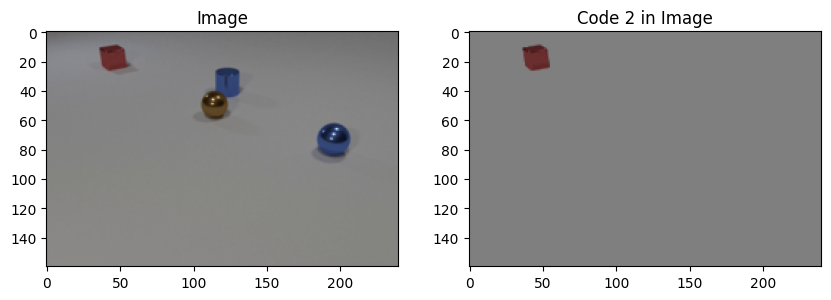

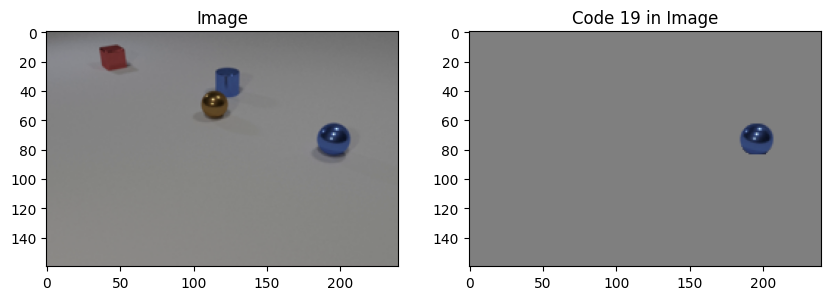

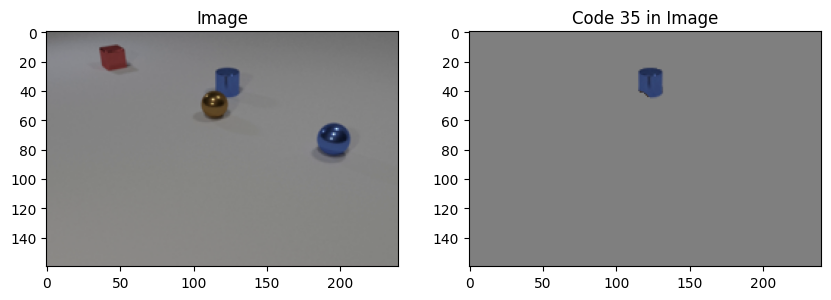

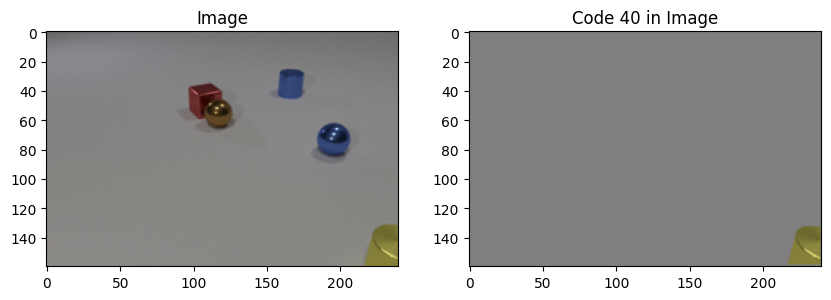

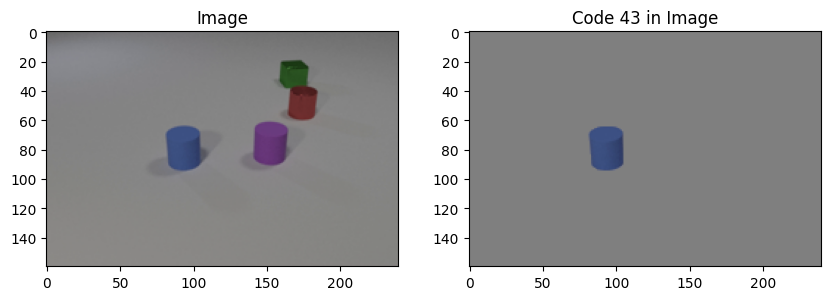

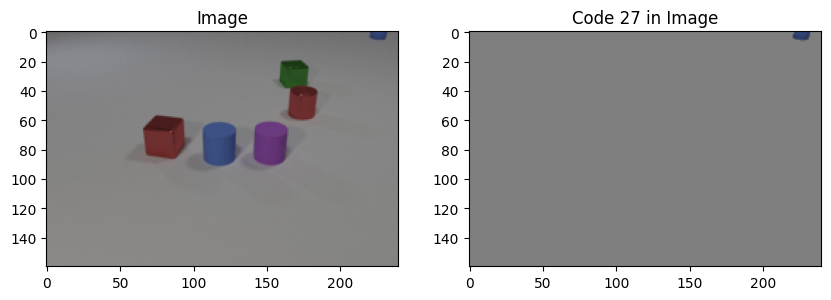

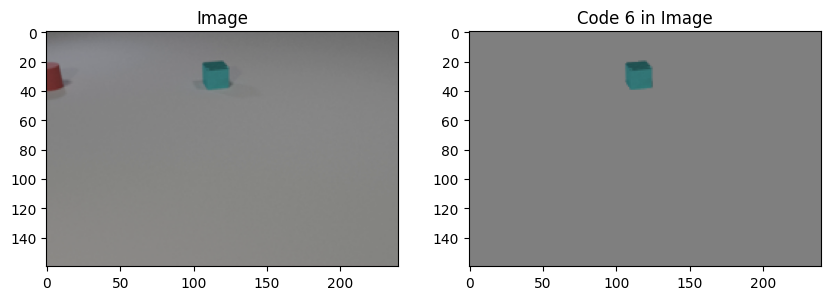

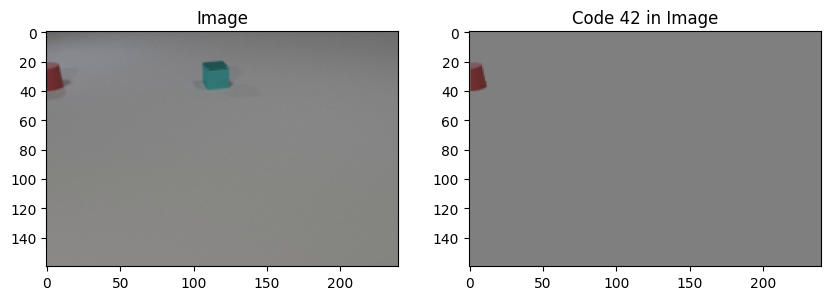

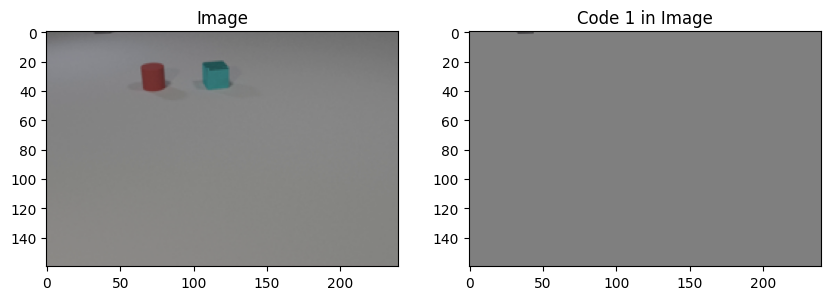

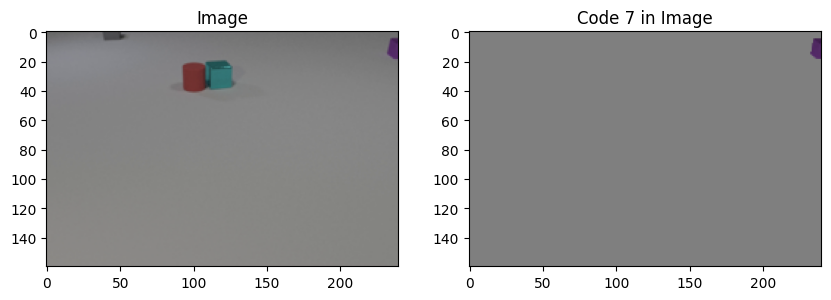

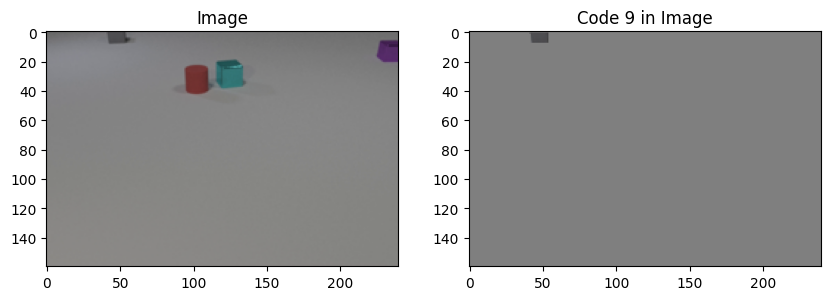

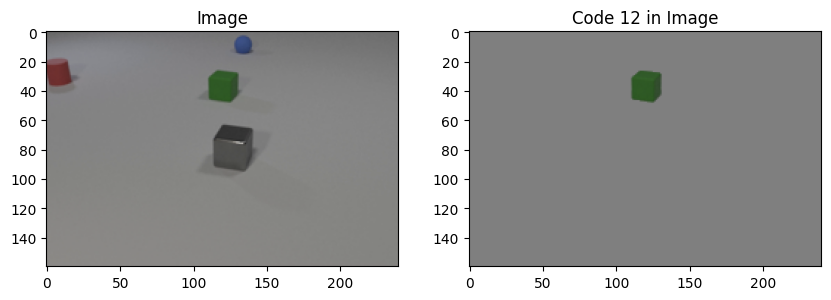

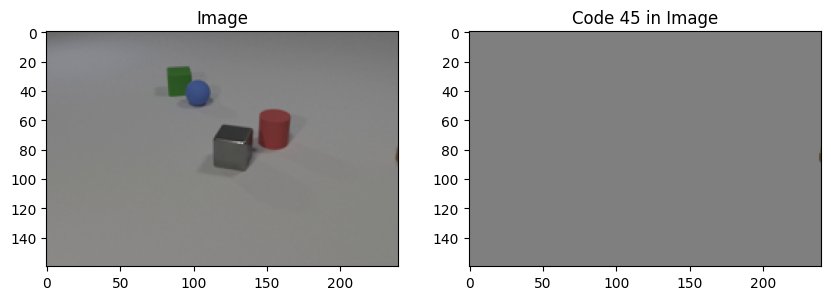

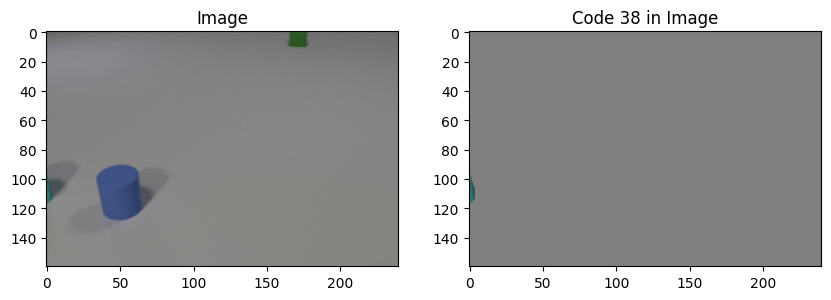

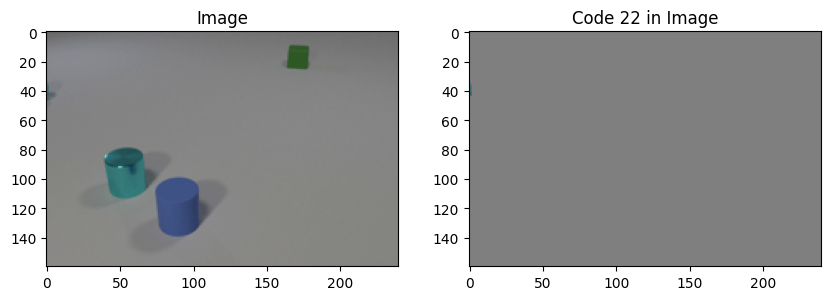

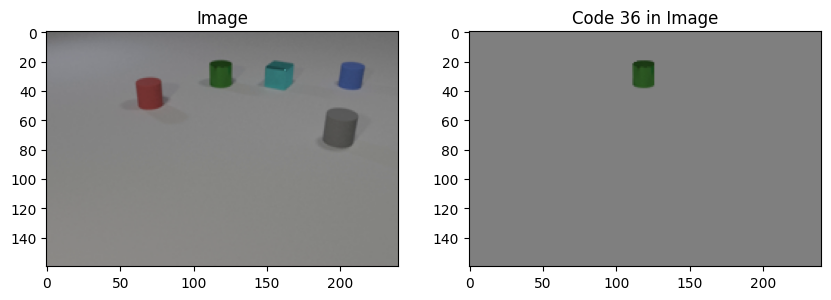

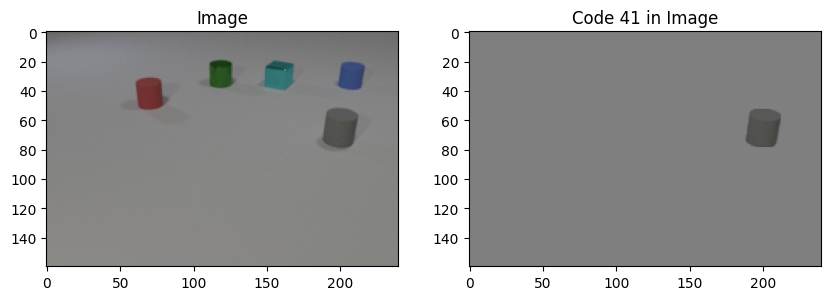

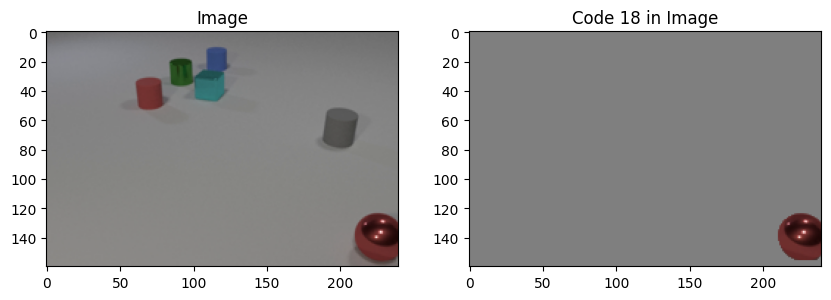

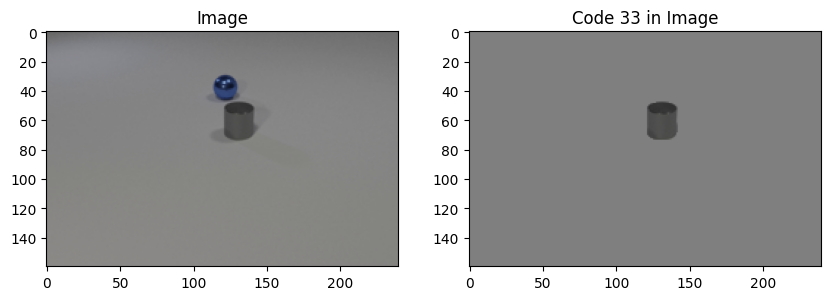

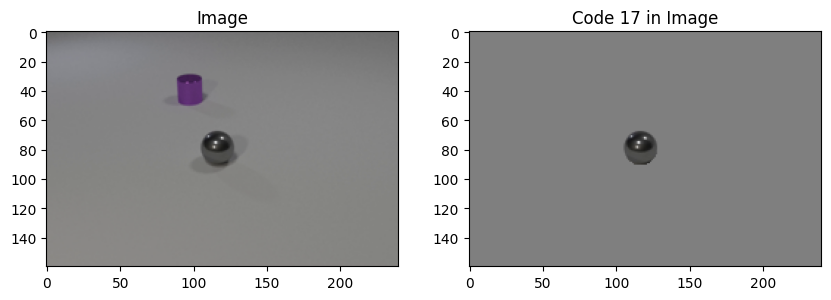

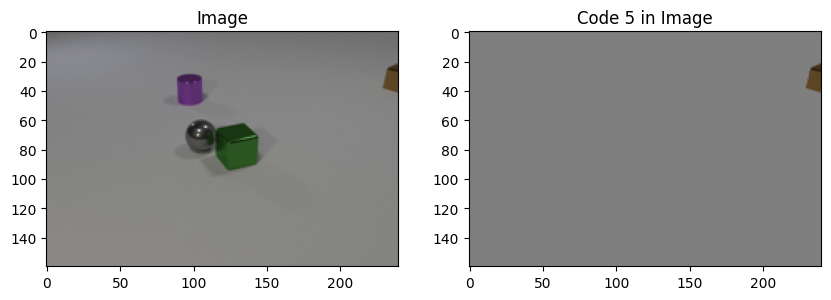

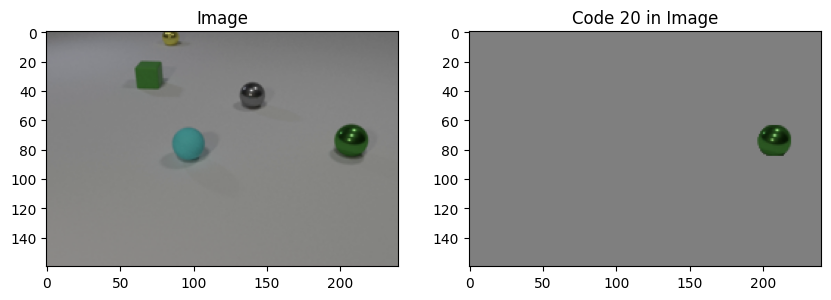

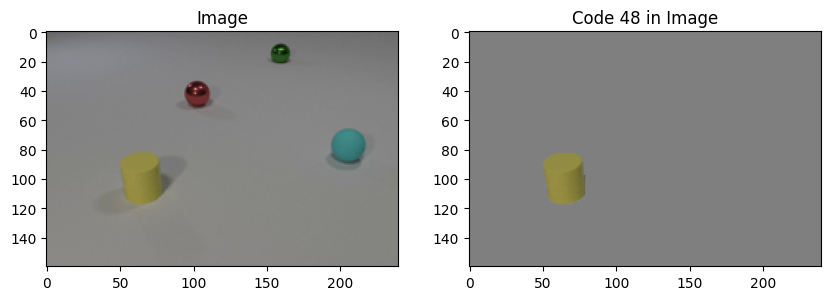

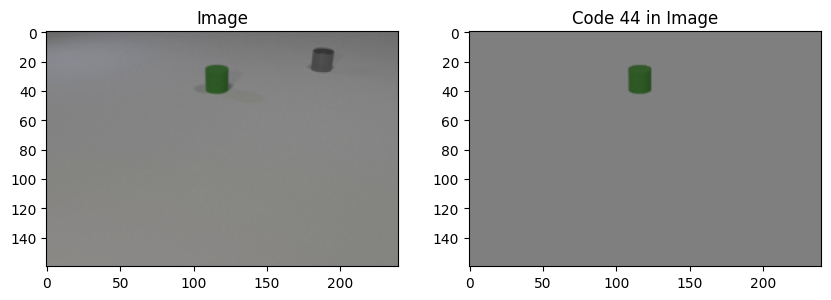

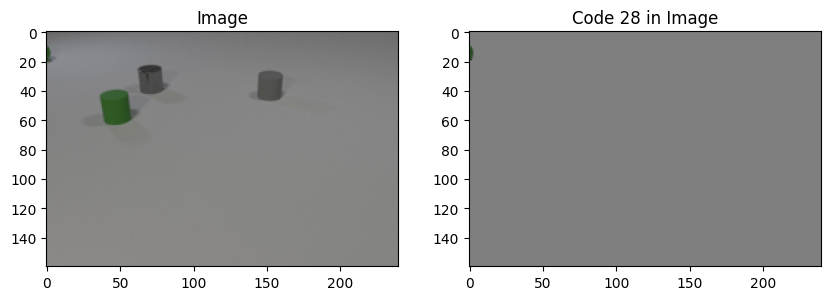

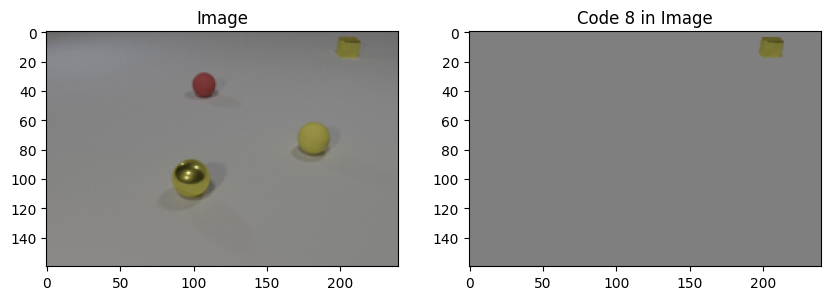

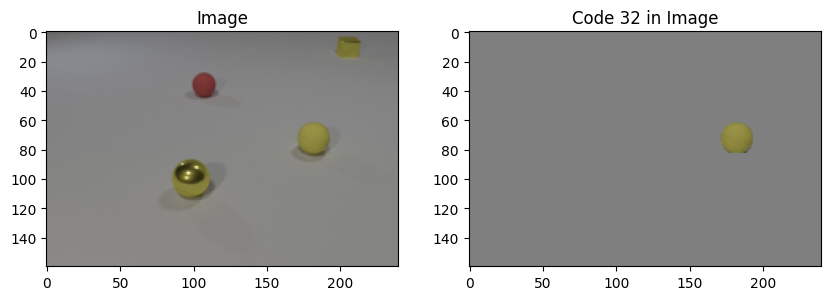

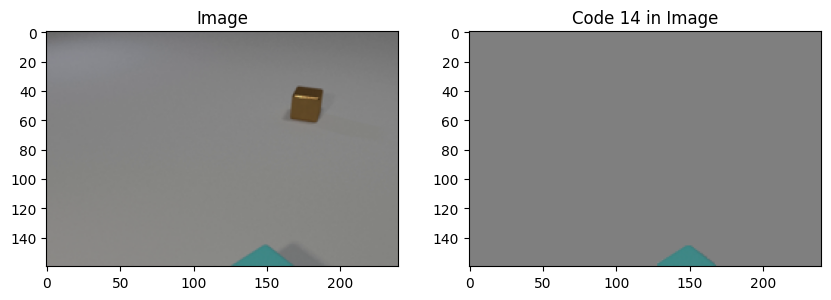

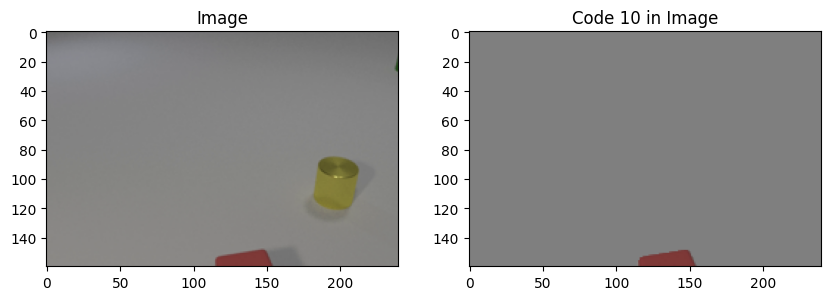

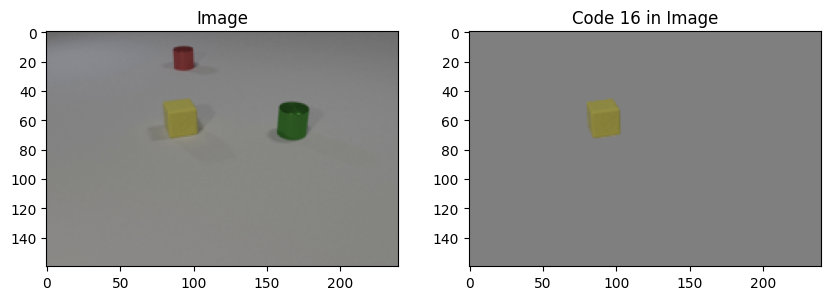

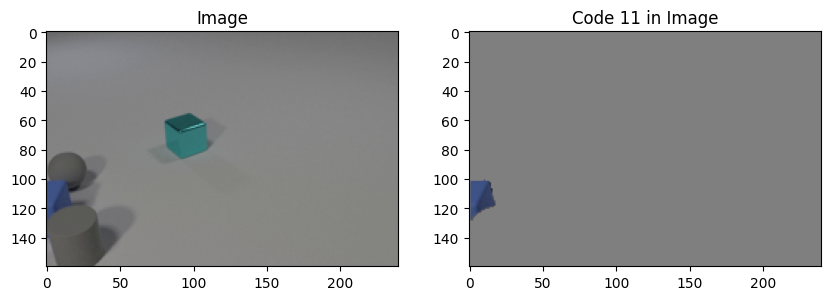

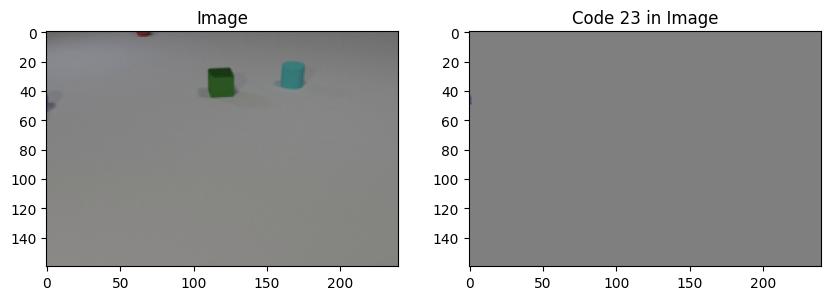

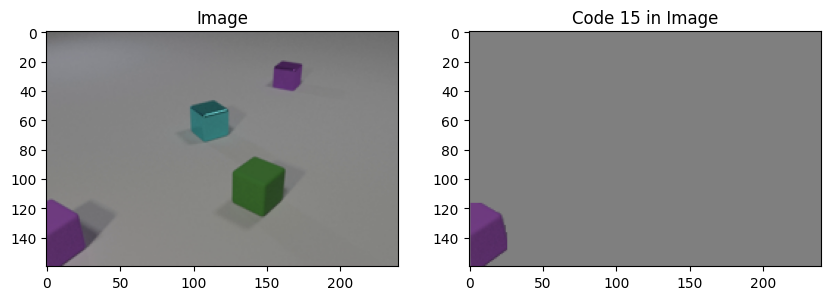

In [269]:
for image_num in range(len(unique_image_set_1)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(tf.cast((unique_image_set_1[image_num]['image'] + 1) * (255 / 2), tf.uint8))
    axes[0].set_title(f"Image")
    
    masked_image = tf.cast(unique_image_set_1[image_num]['image'], 
                           tf.float32) * tf.cast(tf.expand_dims(unique_image_set_1[image_num]['mask'], axis=-1), tf.float32)
    axes[1].imshow(tf.cast((masked_image + 1) * (255 / 2), tf.uint8))
    axes[1].set_title(f"Code {unique_image_set_1[image_num]['code']} in Image")
    plt.show()

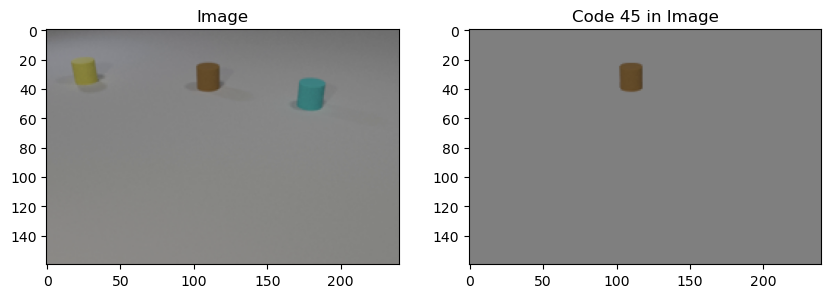

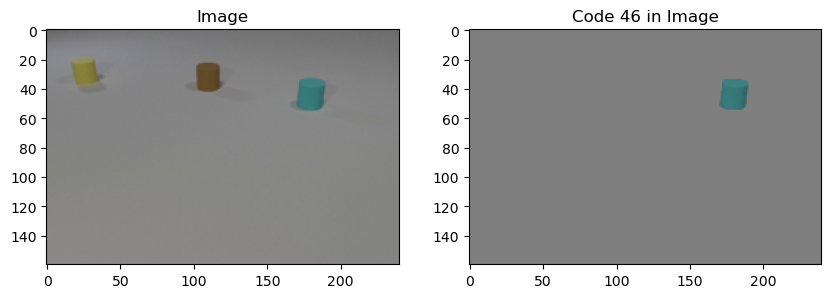

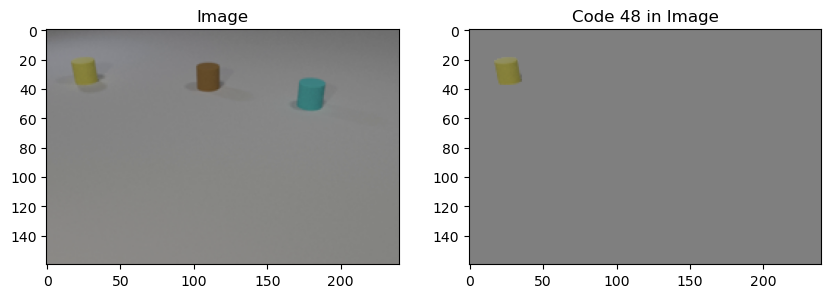

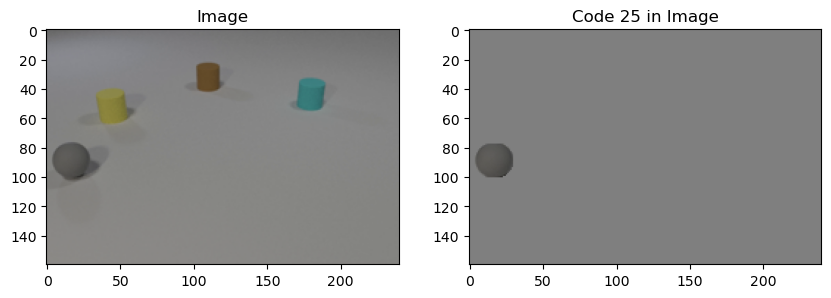

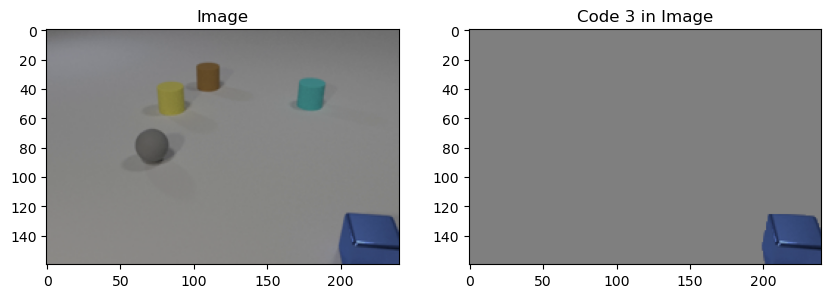

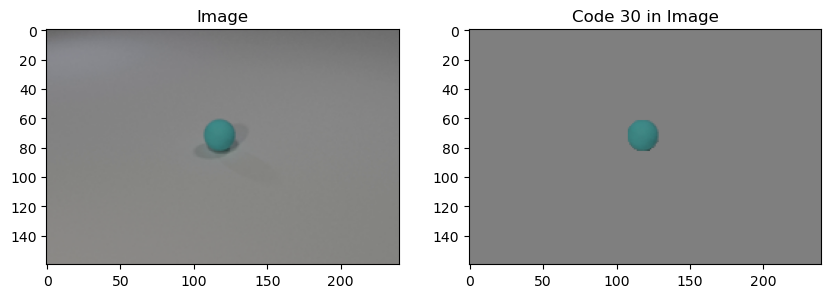

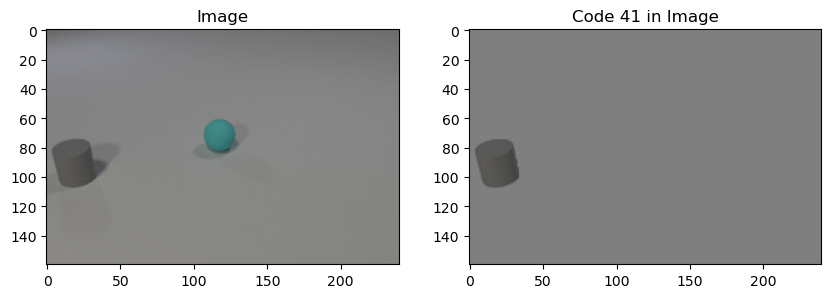

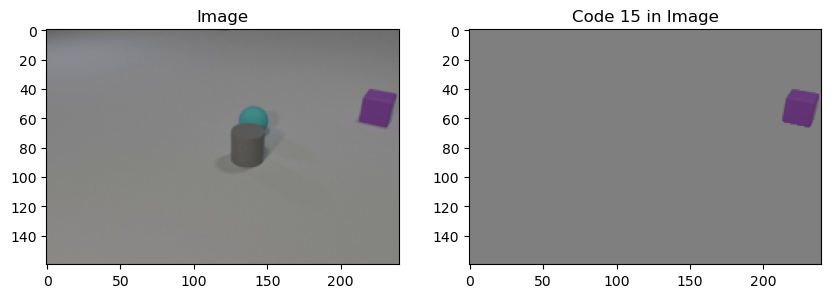

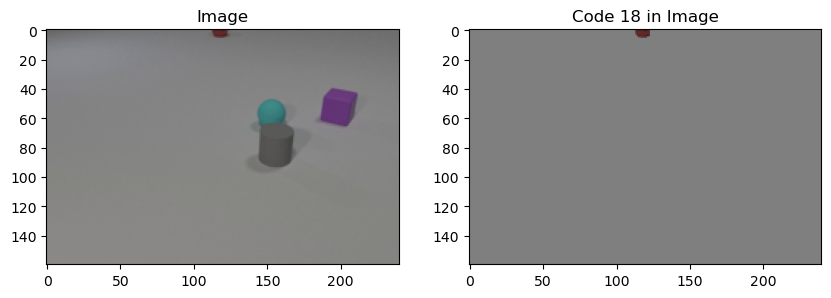

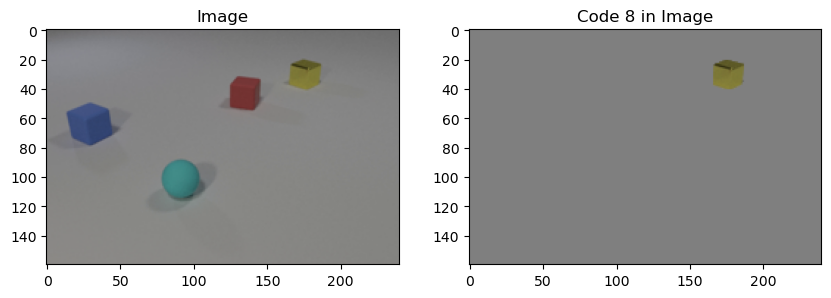

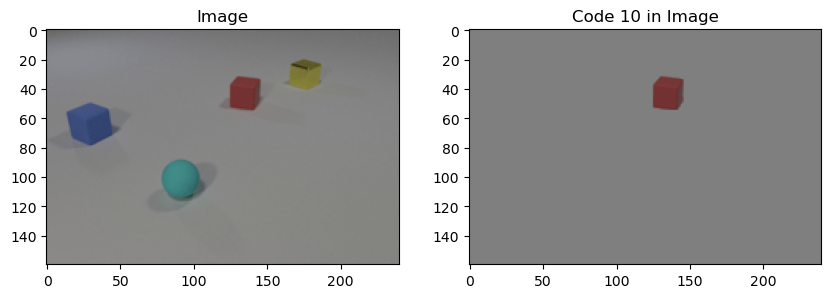

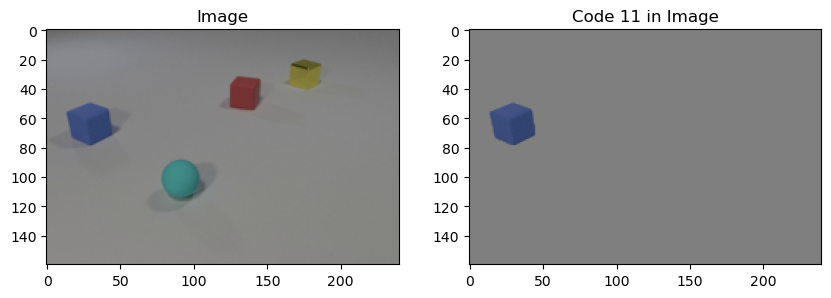

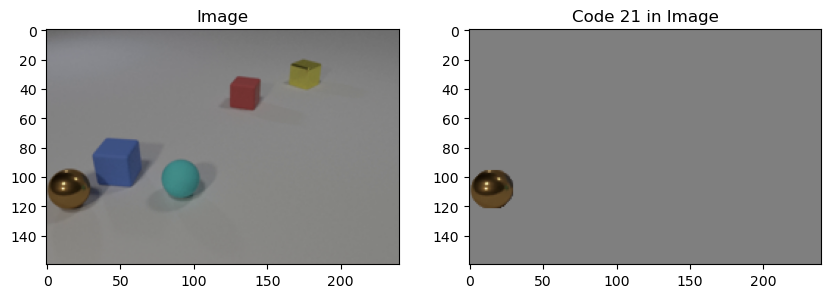

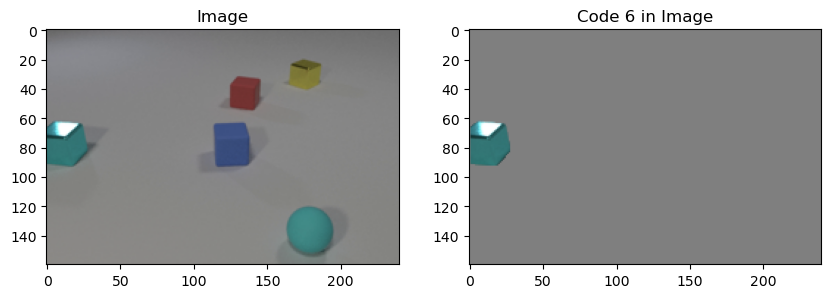

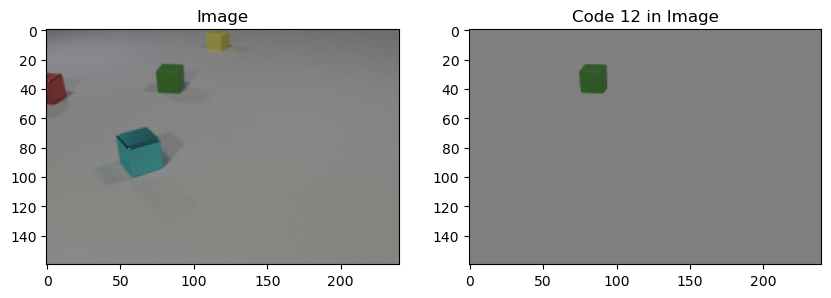

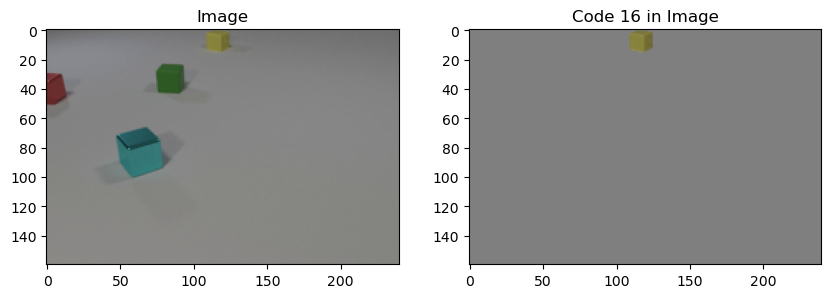

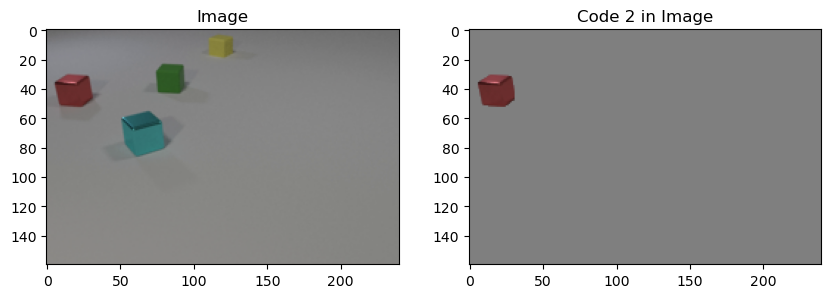

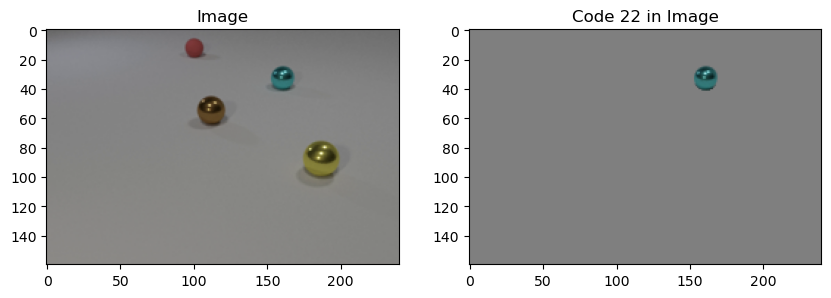

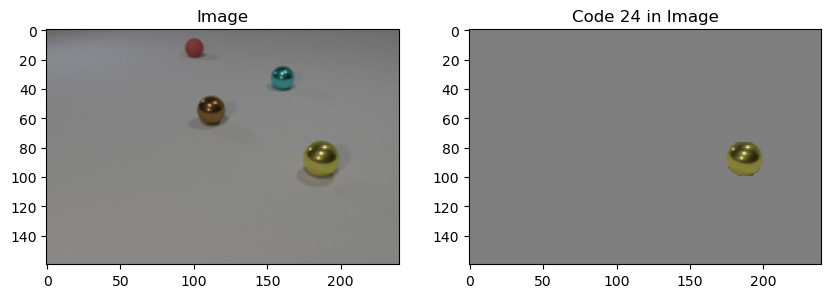

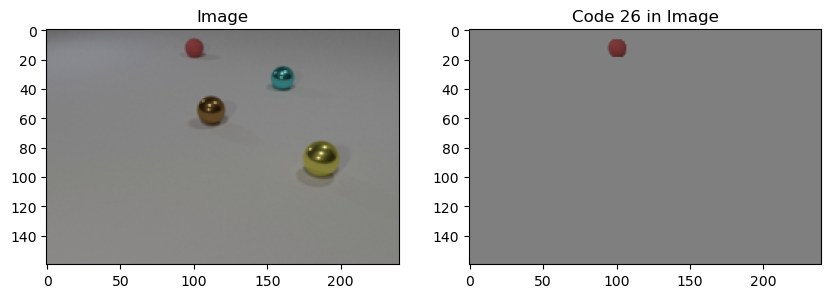

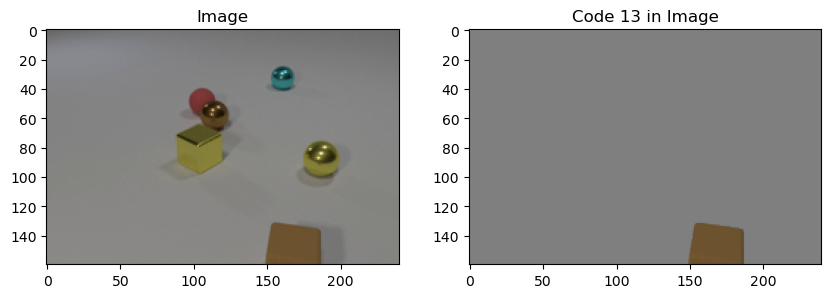

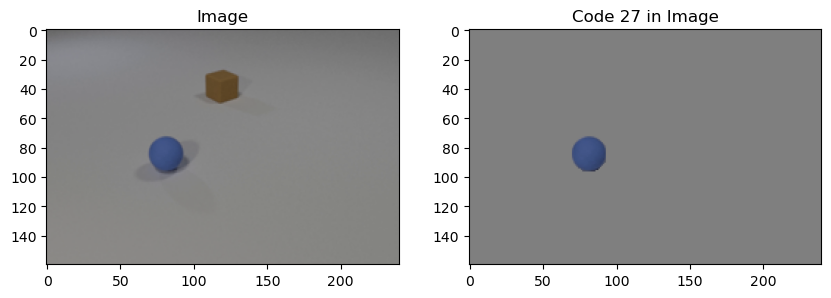

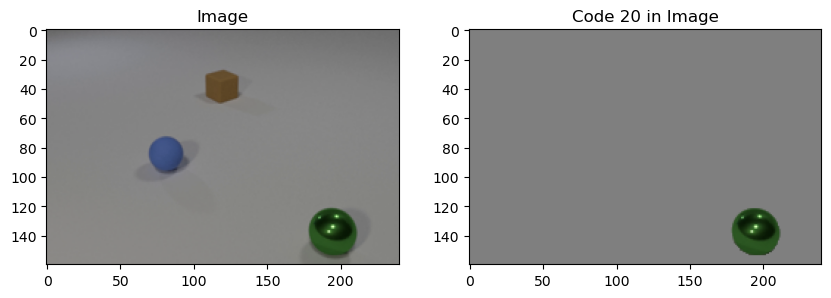

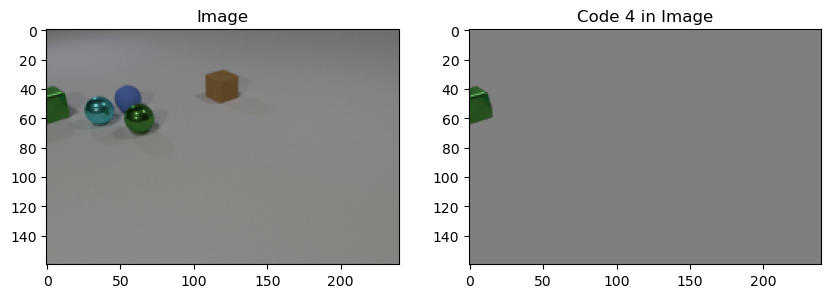

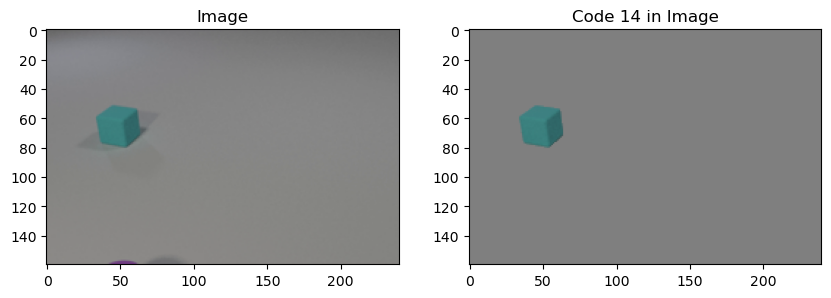

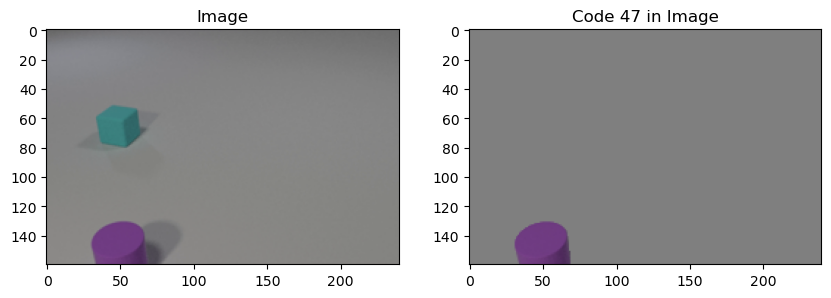

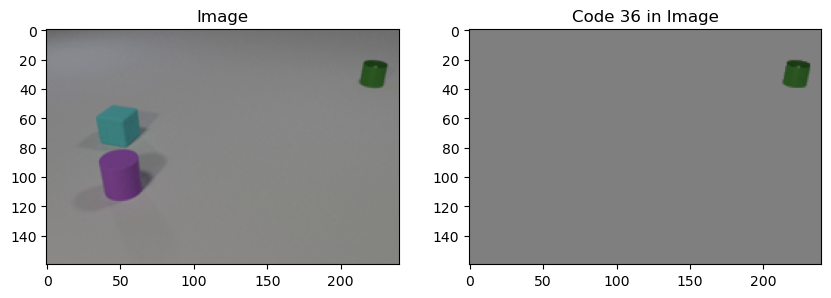

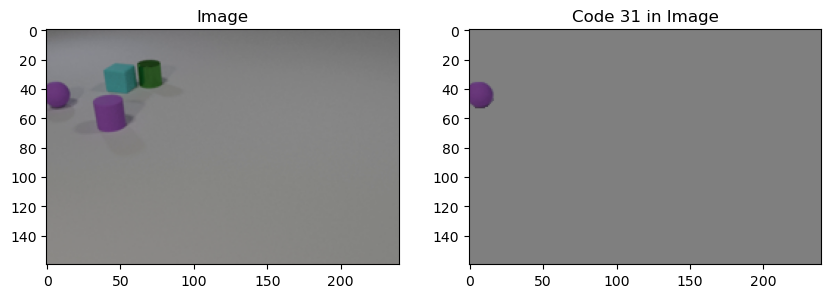

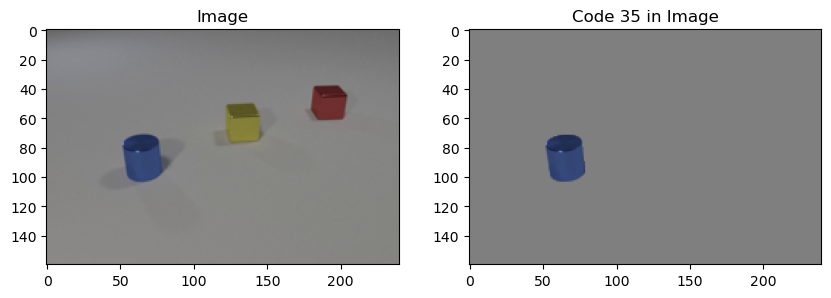

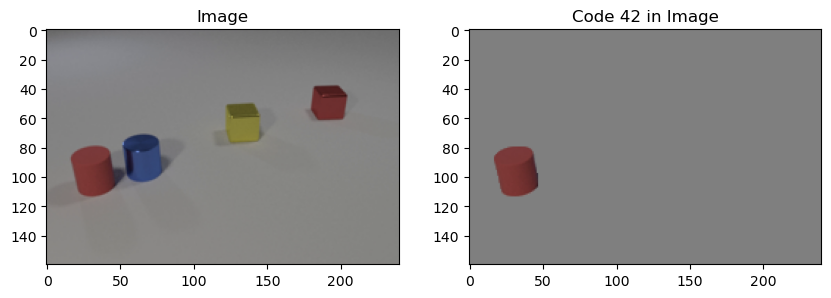

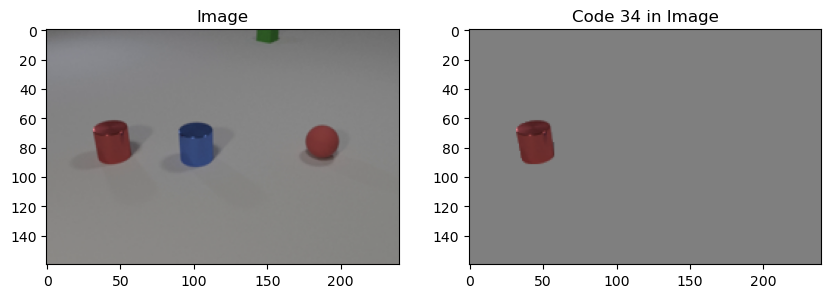

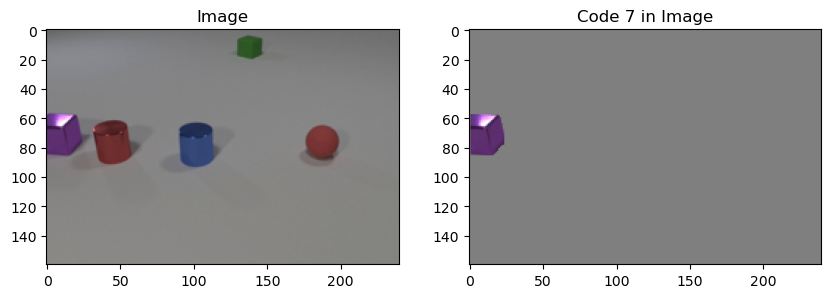

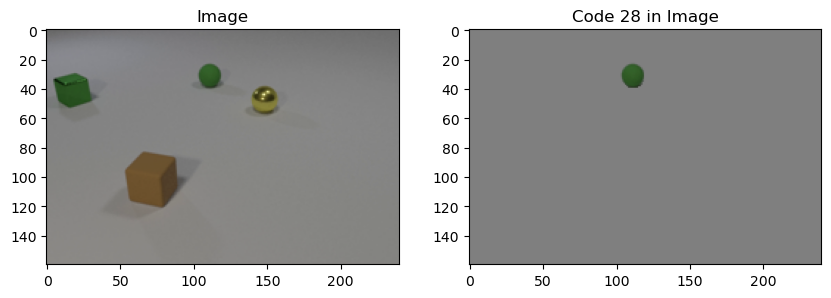

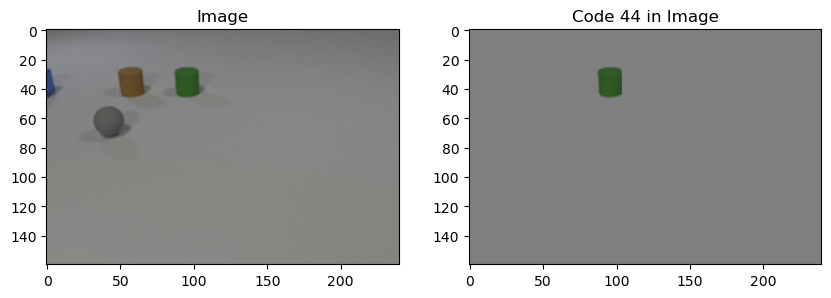

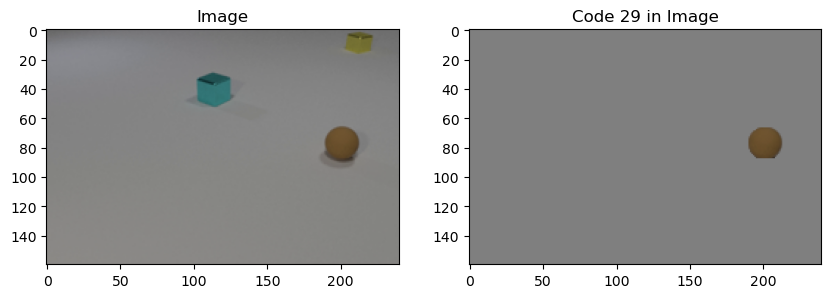

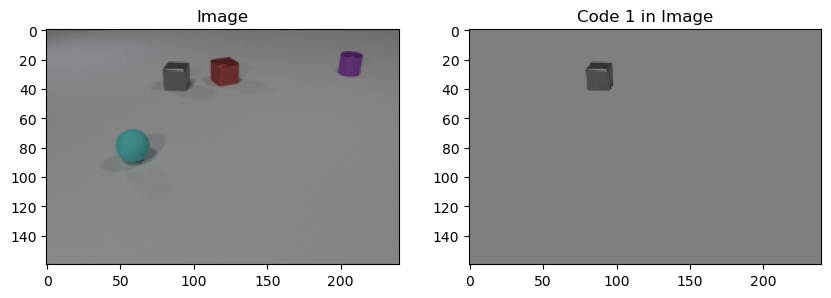

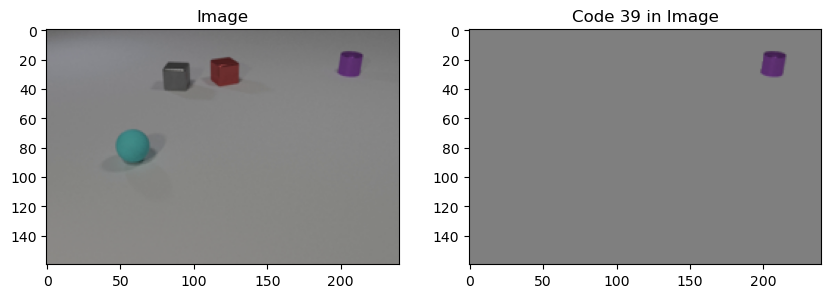

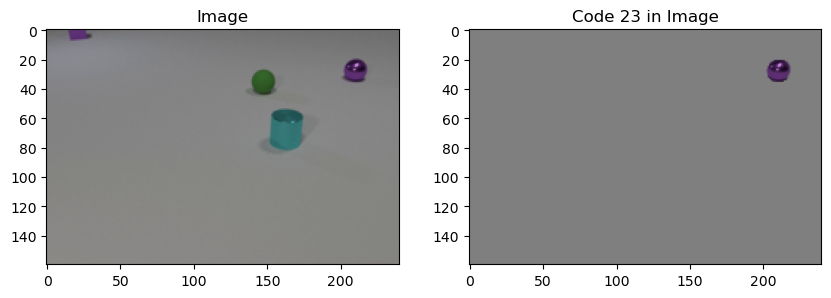

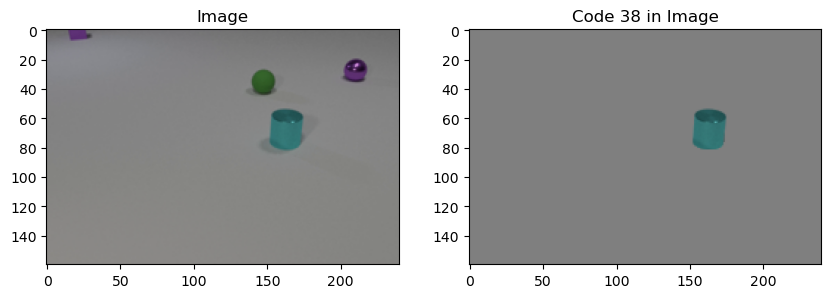

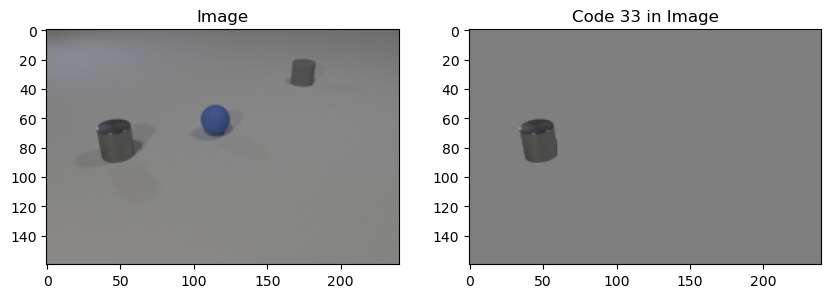

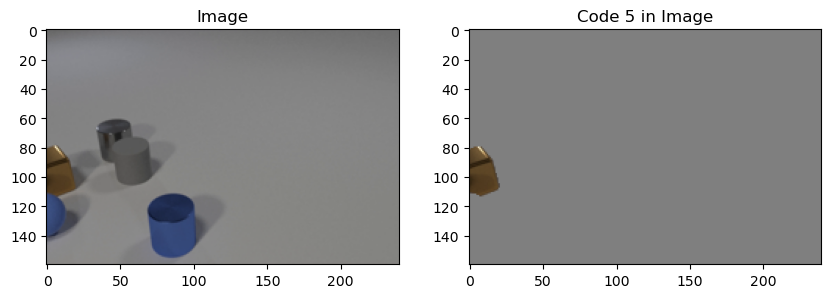

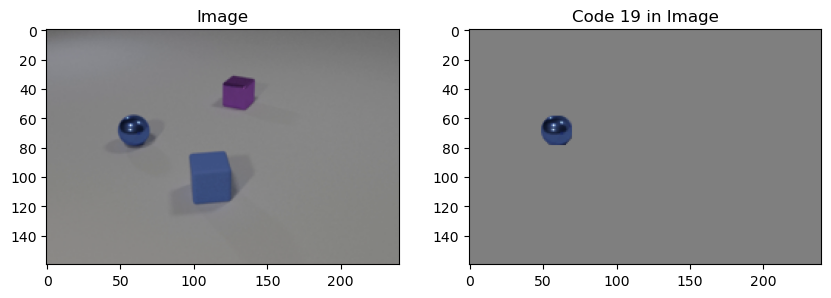

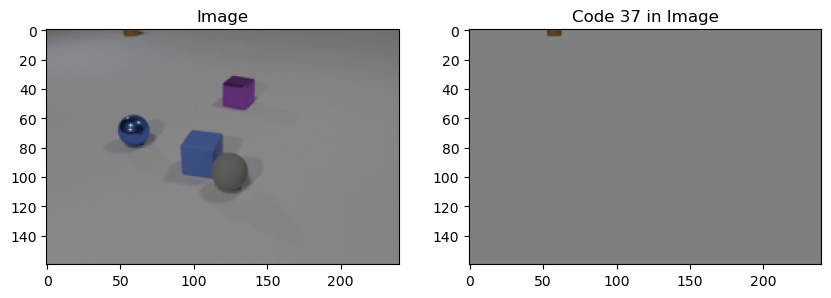

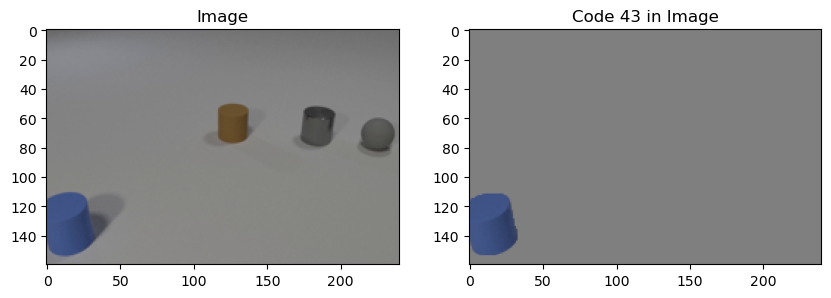

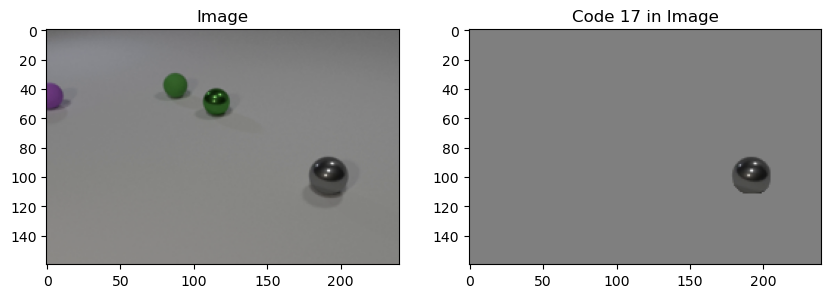

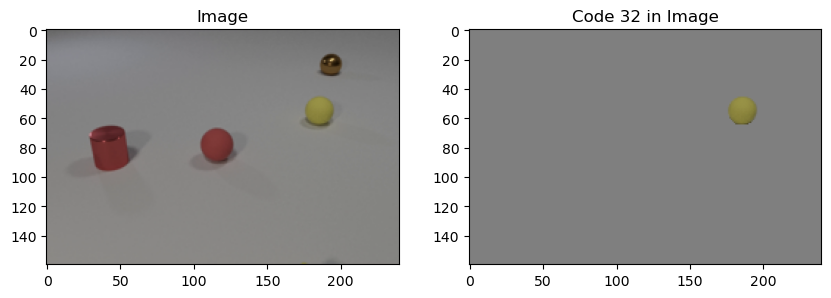

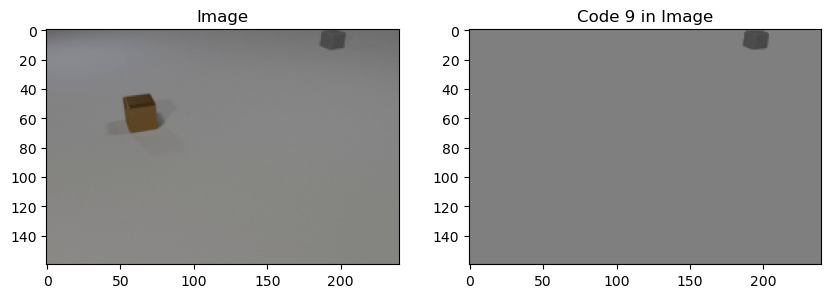

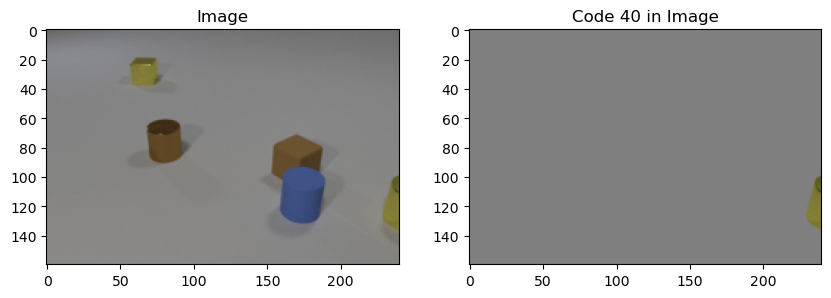

In [ ]:
for image_num in range(len(unique_image_set_2)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(tf.cast((unique_image_set_2[image_num]['image'] + 1) * (255 / 2), tf.uint8))
    axes[0].set_title(f"Image")
    
    masked_image = tf.cast(unique_image_set_2[image_num]['image'], 
                           tf.float32) * tf.cast(tf.expand_dims(unique_image_set_2[image_num]['mask'], axis=-1), tf.float32)
    axes[1].imshow(tf.cast((masked_image + 1) * (255 / 2), tf.uint8))
    axes[1].set_title(f"Code {unique_image_set_2[image_num]['code']} in Image")
    plt.show()

In [270]:
def get_label_dataset(path, batch_size, shuffle=False):
    dataset = LabelDataset(path, batch_size)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataset))
    return dataset

In [290]:
ds = get_label_dataset(path=path, batch_size=32)
list(ds._generator())
# ot = (tf.ClassLabel, tf.ClassLabel, tf.ClassLabel, tf.ClassLabel, tf.float32)
# ds = tf.data.Dataset.from_generator(ds, output_types=ot)

KeyboardInterrupt: 

In [289]:
ot = (tf.string, tf.float32)
ds = tf.data.Dataset.from_generator(ds, output_types=ot)


TypeError: `generator` must be a Python callable.

In [273]:
tf.data.experimental.save(ds, 'save_data')

AttributeError: 'function' object has no attribute '_flat_tensor_specs'

In [ ]:
dataset = tf.data.Dataset.load('save_data')